## **Lifelines classifier:**
> Floris Menninga \
> Datum: 3-03-2025 \
> Versie: 1



In [3]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install scipy
!pip install scikit-learn


import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split

In [19]:
lifelines_df = pd.read_csv("/home/floris/Documenten/Github/Lifelines_Classifier/data/Lifelines_Public_Health_dataset_2024.csv")
lifelines_df.index += 1

lifelines_df.head()

,GENDER,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
1,2,1960,52,55,59,9903,21.9,70.0,91.0,178.5,...,2010,-0.148238,8.0,1.0,3.0,5.0,3.0,4.0,0.0,0.0
2,2,1964,48,51,57,8411,20.9,62.0,93.0,172.5,...,2010,0.357413,10.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0
3,2,1951,58,62,68,9101,24.6,71.0,104.0,170.0,...,2010,-1.730366,9.0,1.0,2.0,2.0,3.0,4.0,0.0,0.0
4,1,1958,54,57,61,9761,25.0,70.5,95.0,169.5,...,2010,0.106612,8.0,2.0,1.0,1.0,5.0,5.0,0.0,0.0
5,2,1963,45,50,57,9201,24.0,61.0,95.0,159.8,...,2006,-1.004381,9.0,4.0,1.0,1.0,5.0,5.0,0.0,0.0


In [5]:
codebook = {
    "attribute": lifelines_df.columns.tolist(), # Gebruik de kolom namen van het df voor de namen hier. 
    "unit": ["geslacht", "", "Jaar", "Jaar", "Jaar", "kg/m2", "kg", "cm", "cm", "cm", "kg/m2", "kg", "cm", "cm", "cm", "kg", "cm", "cm", "cm", "", "", "", "", "", "", "", "mmHg", "mmHg", "BPM", "BPM", "", "", "mmHg", "mmHg", "", "mmol/L", "mmol/L", "mmol/L", "mmol/L", "", "", "", "", "", "", "", "", "gram/day", "kcal/dag", "minuten", "", "minuten", "", "%","", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "Jaar ", "", "", "","", "", "score","score", "score", "score",],
    "dtype": lifelines_df.dtypes.tolist(), # Datatypes hier.
}

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype
attribute,,
GENDER,geslacht,int64
BIRTHYEAR,,int64
AGE_T1,Jaar,int64
AGE_T2,Jaar,int64
AGE_T3,Jaar,int64
...,...,...
NEIGHBOURHOOD4_T2,,float64
NEIGHBOURHOOD5_T2,score,float64
NEIGHBOURHOOD6_T2,score,float64


De "unit" kolommen zijn met de hand ingevuld. \
Optimalisatie: float64 en int64 vervangen door int8, de nummers blijven er toch ver onder. (To-do)

In [20]:
pd.DataFrame({
    "isna": lifelines_df.isna().sum()
})


,isna
GENDER,0
BIRTHYEAR,0
AGE_T1,0
AGE_T2,0
AGE_T3,0
...,...
NEIGHBOURHOOD4_T2,4886
NEIGHBOURHOOD5_T2,4887
NEIGHBOURHOOD6_T2,4884
MENTAL_DISORDER_T1,376


Geen NA's te bekennen.


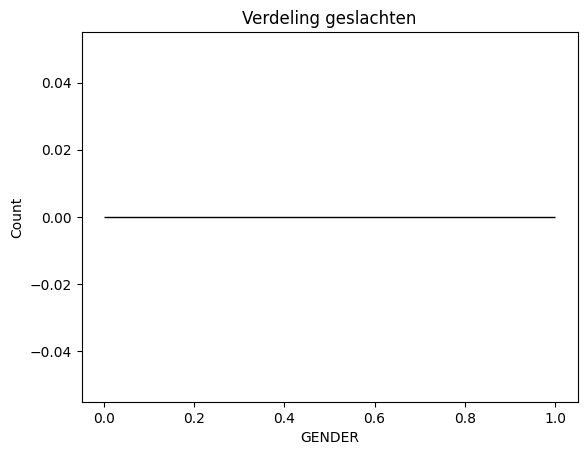

In [22]:
lifelines_df_gender = lifelines_df

lifelines_df_gender["GENDER"] = lifelines_df["GENDER"].map({2: "F", 1: "M"})
lifelines_df_gender.head()

axs = sns.histplot(lifelines_df_gender["GENDER"])
axs.set_title("Verdeling geslachten");

De "1" en "2" zijn vervangen door F voor vrouw en M voor man. 



Ongelijke verdeling van Man/Vrouw datapunten. Meer vrouwen dan mannen. 


In [6]:
lifelines_df.describe()

,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,WAIST_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
count,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,...,16696.000000,16200.000000,11747.000000,11806.000000,11812.000000,11810.000000,11809.000000,11812.000000,16320.000000,13472.000000
mean,1963.883265,46.621766,50.386859,56.395604,9088.022221,25.948491,79.580642,99.176186,174.920394,90.150557,...,2009.363201,-0.576549,8.218609,1.942317,1.451490,1.755631,3.689813,4.075855,0.079534,0.085065
std,11.159835,11.179438,11.128222,11.160991,703.594702,4.110023,14.718271,9.177001,9.352034,11.800292,...,1.463493,1.079084,1.460666,0.821344,0.680361,1.038783,1.016746,0.810044,0.320736,0.333972
min,1927.000000,18.000000,20.000000,25.000000,1015.000000,15.400000,42.000000,62.000000,137.000000,60.000000,...,2006.000000,-7.121883,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1957.000000,40.000000,43.000000,49.000000,8496.500000,23.200000,69.000000,93.000000,168.000000,82.000000,...,2010.000000,-1.194383,8.000000,1.000000,1.000000,1.000000,3.000000,4.000000,0.000000,0.000000
50%,1964.000000,47.000000,51.000000,57.000000,9281.000000,25.400000,78.000000,98.000000,174.000000,90.000000,...,2010.000000,-0.580492,8.000000,2.000000,1.000000,1.000000,4.000000,4.000000,0.000000,0.000000
75%,1971.000000,54.000000,57.000000,64.000000,9654.000000,28.000000,89.000000,104.000000,181.500000,98.000000,...,2010.000000,0.183076,9.000000,2.000000,2.000000,2.000000,4.000000,5.000000,0.000000,0.000000
max,1995.000000,84.000000,88.000000,95.000000,9998.000000,53.800000,158.000000,185.000000,207.000000,156.000000,...,2010.000000,2.933054,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


In [7]:
def by_unit(*units):
    # Retourneert een lijst van attributen die gevraagde eenheden hebben
    return [attribute for attribute, unit in zip(codebook["attribute"], codebook["unit"]) if unit in units]

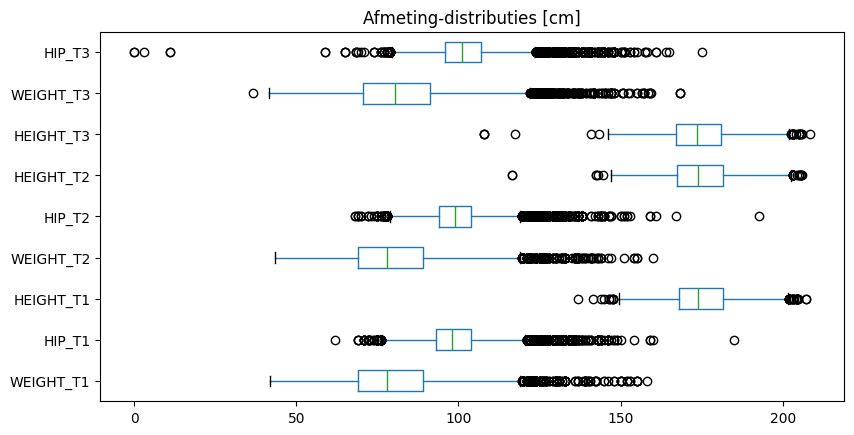

In [8]:
axs = lifelines_df[by_unit("cm")].boxplot(grid=False, vert=False, figsize=(9.6, 4.8))
axs.set_title("Afmeting-distributies [cm]");

Er zijn een groot aantal uitschieters.

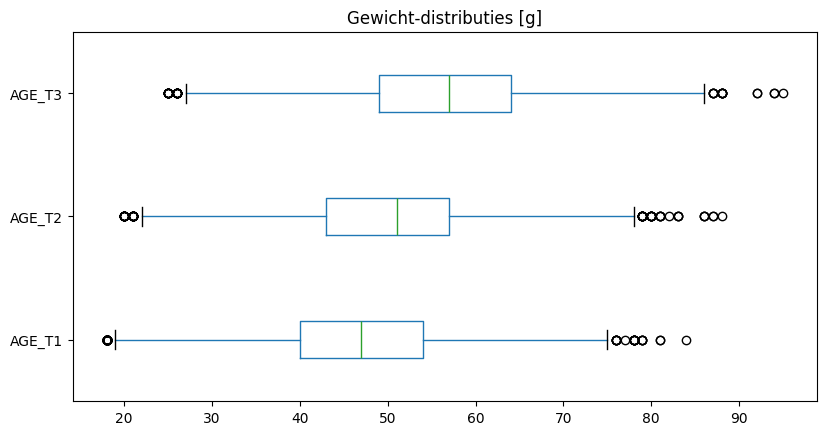

In [9]:
axs = lifelines_df[by_unit("Jaar")].boxplot(grid=False, vert=False, figsize=(9.6, 4.8))
axs.set_title("Gewicht-distributies [g]");

Tussen de verschillende meetpunten (T1 t/m T3) liggen de leeftijden steeds wat hoger, zoals verwachts. 

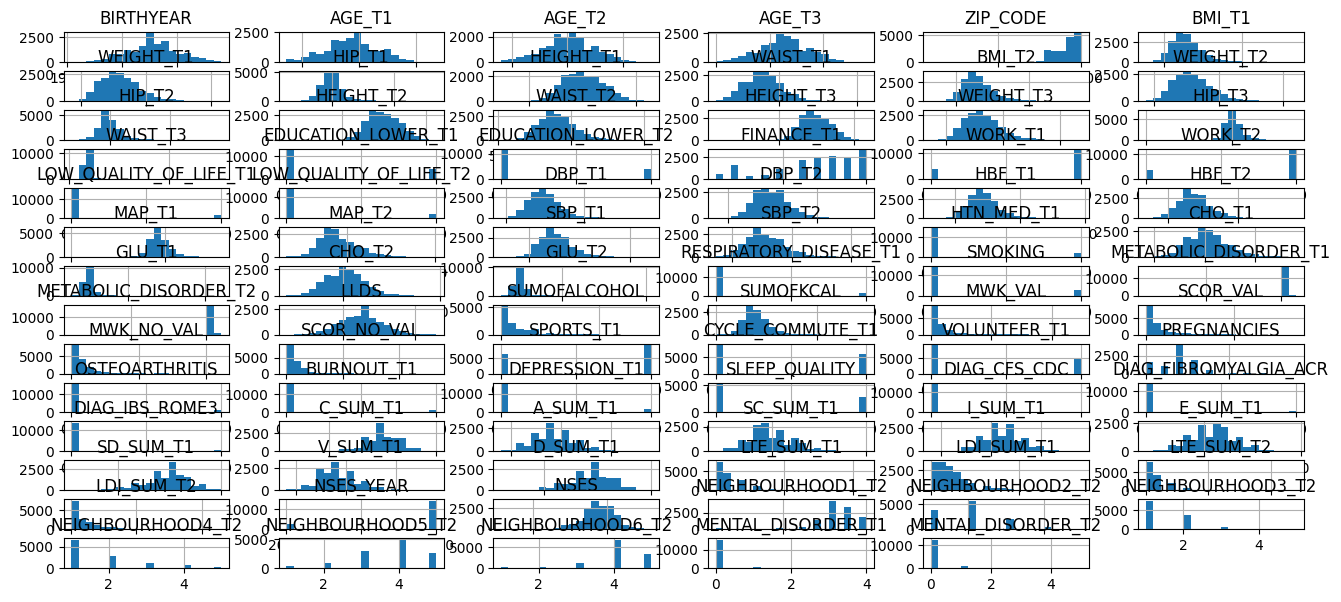

In [10]:
lifelines_df.hist(bins=20, layout=(20, 6), figsize=(16.0, 10));

To-do: overzichtelijker maken.... \
To-do: data filteren? 


Exploratieve data analyze: Bivariaat 

In [11]:
grouped = lifelines_df[["GENDER", "AGE_T1"]].groupby("GENDER")


for label1, group1 in grouped:
    for label2, group2 in grouped:
        if label1 < label2:
            t, p = stats.ttest_ind(group1["AGE_T1"], group2["AGE_T1"]) 
            print(f"{label1} vs. {label2}:\t{p = :8.1e}")

F vs. M:	p =  4.7e-10


Interpretatie toevoegen...

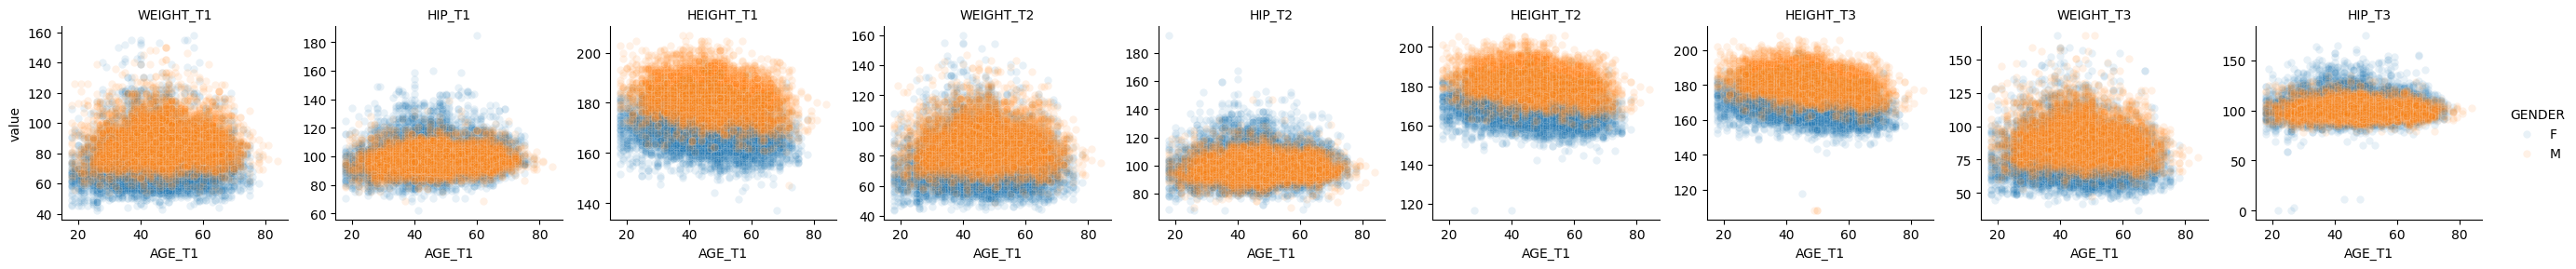

In [12]:
subdata = pd.melt(lifelines_df, id_vars=["AGE_T1", "GENDER"], value_vars=by_unit("cm"))
g = sns.FacetGrid(subdata, col="variable", sharey=False, hue="GENDER")
g.map_dataframe(sns.scatterplot, x="AGE_T1", y="value", alpha=0.1).set_titles(col_template="{col_name}").add_legend();

In [13]:
lifelines_df[by_unit("","kg", "cm")]

,BIRTHYEAR,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,BMI_T2,WEIGHT_T2,HIP_T2,HEIGHT_T2,WAIST_T2,...,D_SUM_T1,LTE_SUM_T1,LDI_SUM_T1,LTE_SUM_T2,LDI_SUM_T2,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2
1,1960,21.9,70.0,91.0,178.5,21.9,70.0,97.0,177.0,80.0,...,30.0,2.0,8.0,0.0,4.0,-0.148238,8.0,1.0,3.0,5.0
2,1964,20.9,62.0,93.0,172.5,20.6,60.0,92.0,172.0,75.0,...,18.0,0.0,4.0,3.0,4.0,0.357413,10.0,1.0,1.0,1.0
3,1951,24.6,71.0,104.0,170.0,25.6,74.0,104.0,168.0,95.0,...,29.0,1.0,0.0,0.0,1.0,-1.730366,9.0,1.0,2.0,2.0
4,1958,25.0,70.5,95.0,169.5,25.2,72.0,98.0,168.0,91.0,...,35.0,0.0,0.0,1.0,0.0,0.106612,8.0,2.0,1.0,1.0
5,1963,24.0,61.0,95.0,159.8,24.5,64.5,97.0,159.0,85.0,...,33.0,0.0,0.0,0.0,0.0,-1.004381,9.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16692,1963,23.9,82.0,97.0,185.0,25.6,84.5,95.0,186.0,93.0,...,33.0,0.0,1.0,3.0,1.0,-0.610944,7.0,3.0,3.0,5.0
16693,1970,29.6,85.0,99.0,170.0,31.1,89.5,110.0,170.0,96.0,...,24.0,0.0,2.0,1.0,4.0,0.249078,7.0,3.0,3.0,4.0
16694,1981,27.0,93.0,95.5,186.0,26.3,91.5,104.0,183.5,88.0,...,30.0,1.0,0.0,0.0,0.0,-1.394716,8.0,2.0,1.0,2.0
16695,1953,26.2,72.0,99.0,165.5,26.8,70.0,94.0,163.0,95.0,...,32.0,1.0,1.0,1.0,2.0,-2.653102,NaN,NaN,NaN,NaN


In [14]:
# langzaam! Later weer aanzetten.. 
#sns.pairplot(lifelines_df[by_unit("geslacht","kg", "cm")],hue="GENDER", plot_kws={'alpha': 0.1});

In [15]:
#axs = sns.heatmap(lifelines_df["GENDER", "AGE_T1", ""].corr(), annot=True, annot_kws={"fontsize": "x-small"}, cmap="jet", vmin=0.0, vmax=1.0, square=True)
#axs.set_title("Paarsgewijze correlaties ($R$)");

Machine learning:


In [16]:

X = lifelines_df[["GENDER", "AGE_T1", "WORK_T1", "HEIGHT_T1", "WEIGHT_T1", "EDUCATION_LOWER_T1", "FINANCE_T1"]].to_numpy()
y = lifelines_df["LOW_QUALITY_OF_LIFE_T1"].to_numpy()

X.shape, X.dtype, y.shape, y.dtype

((16696, 7), dtype('O'), (16696,), dtype('float64'))

In [17]:
# Er zitten NA's in de y, hier worden ze verwijderd:
#y = y[~np.isnan(y)]

# Na's verwijderen zorgt voor een oneven aantal observaties, missende waarden imputeren i.p.v. verwijderen:
y = np.nan_to_num(y)
X = np.nan_to_num(X)

Aan de hand van de datapunten bescheven bij X, voorspeld wordt of mensen gelukkig zijn of niet (LOW_QUALITY_OF_LIFE_T1)
In het metadata bestand dat bij deze dataset hoort betekekend dat de ondervraagde mensen hun leven als "poor/mediocre" bechreven. 

To-do: andere features selecteren voor X.


In [18]:
# Datasplit:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

Er is nu een split gemaakt van 80% train data en 20% evaluatiedata. 

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

models = [
    DummyClassifier,
    DecisionTreeClassifier,
    GaussianNB,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    MLPClassifier
]

In [22]:
# Cross-validatie
from sklearn.model_selection import cross_validate

metric_scores = {}
for model in models:
    scores = cross_validate(model(), X, y, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/tree/_classes.py", line 1024, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'M'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/tree/_classes.py", line 1024, in fit
    super()._fit(
    ~~~~~~~~~~~~^
        X,
        ^^
    ...<2 lines>...
        check_input=check_input,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self, X, y, validate_separately=(check_X_params, check_y_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py", line 2956, in validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/floris/Documenten/Github/Lifelines_Classifier/.venv/lib64/python3.13/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'F'


Crossvalidatie uitvoeren op de train dataset. (Niet perse nodig met een train / test datasplit maar kan beter zijn. )

In [ ]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=7).fit(X, y)

pd.DataFrame({"Attribute": codebook["attribute"][:-1], "Score": selector.scores_}).sort_values("Score", ascending=False).set_index("Attribute")

ValueError: All arrays must be of the same length